# Imports

In [1]:
import duckdb
import dtale
import pandas as pd
import requests
import re

In [2]:
from dotenv import dotenv_values, find_dotenv
from pathlib import Path

# Config

## Data Paths

In [3]:
path_data = Path() / '..' / 'data'
path_data_raw = path_data / 'raw'

## Credentials

In [4]:
config = dotenv_values(find_dotenv())
ad_api_key = config.get('AMBERDATA_API_KEY')

# Get Original Data

In [11]:
import os

path_original_raw_data = Path() / '..' / '..' / 'token_labs_python' / 'data' / 'raw'
df_raw_data = (
    pd.read_csv(path_original_raw_data / 'ohlc_1d_binance_bybit_swaps.csv')
    .astype({'datetime':'datetime64[ns]'})
)

In [12]:
df_raw_data.head()

,instrument,open,high,low,close,volume,exchange,datetime
0,1INCHUSDT,2.7000,2.9562,1.7498,2.2801,71519996.0,binance,2020-12-25
1,1INCHUSDT,2.2823,2.4260,1.5595,1.5960,72874458.0,binance,2020-12-26
2,1INCHUSDT,1.5960,1.6540,1.0415,1.0636,96158019.0,binance,2020-12-27
3,1INCHUSDT,1.0615,1.2800,1.0409,1.1175,52486917.0,binance,2020-12-28
4,1INCHUSDT,1.1172,1.1204,0.7563,0.8866,95372584.0,binance,2020-12-29


In [93]:
conn = duckdb.connect(path_data / "crypto_data.db")
conn.register("temp_df", df_raw_data)
conn.execute('DROP TABLE IF EXISTS amberdata.perps_ohlc_1d')
conn.execute('DROP TABLE IF EXISTS amberdata.ohlcv_perps_1d')
conn.execute("""
    CREATE TABLE amberdata.ohlcv_perps_1d AS
    SELECT * FROM temp_df 
    ORDER BY exchange, instrument, datetime
""")
conn.execute(
    """
        CREATE UNIQUE INDEX IF NOT EXISTS ohlcv_perps_1d_unique_idx
        ON amberdata.ohlcv_perps_1d (exchange, instrument, datetime);
    """
)
conn.close()

In [92]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    df_ohlcv_perps_1d = conn.execute("""
        SELECT 
            *,
            -- CURRENT_TIMESTAMP AS updated_at
        FROM amberdata.ohlcv_perps_1d
        -- LIMIT 5;
    """).fetchdf()

df_ohlcv_perps_1d.shape

(453404, 8)

In [42]:
ad_api_key

'UAK2f2c0a371906783a4dcd4db6e26db0f5'

In [43]:
result.columns

Index(['instrument', 'open', 'high', 'low', 'close', 'volume', 'exchange',
       'datetime'],
      dtype='object')

In [32]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    df_perps = conn.execute("""
        SELECT 
            exchange,
            instrument
        FROM amberdata.exchange_reference
        WHERE contract_period = 'perpetual'
    """).fetchdf()

In [33]:
df_perps

,exchange,instrument
0,binance,1000000MOGUSDT
1,binance,1000BONKUSDC
2,binance,1000BONKUSDT
3,binance,1000BTTCUSDT
4,binance,1000CATUSDT
...,...,...
1090,bybit,ZKJUSDT
1091,bybit,ZKUSDT
1092,bybit,ZRCUSDT
1093,bybit,ZROUSDT


In [48]:
df_perps.query('exchange == "bybit"').sort_values('instrument')

,exchange,instrument
514,bybit,10000000AIDOGEUSDT
515,bybit,1000000BABYDOGEUSDT
516,bybit,1000000CHEEMSUSDT
517,bybit,1000000MOGUSDT
518,bybit,1000000PEIPEIUSDT
...,...,...
1090,bybit,ZKJUSDT
1091,bybit,ZKUSDT
1092,bybit,ZRCUSDT
1093,bybit,ZROUSDT


In [34]:
dict_instruments = {exchange:list(df_perps.query('exchange == @exchange')['instrument']) for exchange in ['binance','bybit']}

In [36]:
from duckdb import sql

In [41]:
sql("SELECT * FROM df_perps WHERE instrument == 'DOTECOUSDT'")

┌──────────┬────────────┐
│ exchange │ instrument │
│ varchar  │  varchar   │
├──────────┼────────────┤
│ binance  │ DOTECOUSDT │
└──────────┴────────────┘

In [ ]:
df_instruments.query('instrument == "DOTECOUSDT"')

In [52]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    conn.execute("""
        DROP TABLE IF EXISTS amberdata.ohlcv_info_futures
    """)

    conn.execute(
        """
            CREATE TABLE IF NOT EXISTS amberdata.ohlcv_info_futures (
                exchange VARCHAR,
                instrument VARCHAR,
                trading_start_date DATETIME,
                trading_end_date DATETIME,
                active BOOLEAN,
                updated_at TIMESTAMP
            );
        """
    )

    conn.execute(
        """
            CREATE UNIQUE INDEX IF NOT EXISTS ohlcv_info_futures_unique_idx
            ON amberdata.ohlcv_info_futures (exchange, instrument);
        """
    )

In [119]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    result = conn.execute("""
            SELECT *
            FROM amberdata.ohlcv_info_futures
        """
    ).fetch_df()

display(result)

,exchange,instrument,trading_start_date,trading_end_date,active,updated_at
0,binance,1000000MOGUSDT,2024-11-07,2025-01-15,True,2025-01-16 10:30:37.368763
1,binance,1000BONKUSDC,2024-05-02,2025-01-15,True,2025-01-16 10:30:37.368763
2,binance,1000BONKUSDT,2023-11-22,2025-01-15,True,2025-01-16 10:30:37.368763
3,binance,1000BTTCUSDT,2022-01-26,2022-04-11,False,2025-01-16 10:30:37.368763
4,binance,1000CATUSDT,2024-10-21,2025-01-15,True,2025-01-16 10:30:37.368763
...,...,...,...,...,...,...
1537,bybit,ZKJUSDT,2024-06-17,2025-01-15,True,2025-01-16 10:30:39.345521
1538,bybit,ZKUSDT,2024-03-22,2025-01-15,True,2025-01-16 10:30:39.345521
1539,bybit,ZRCUSDT,2024-11-25,2025-01-15,True,2025-01-16 10:30:39.345521
1540,bybit,ZROUSDT,2024-06-20,2025-01-15,True,2025-01-16 10:30:39.345521


In [120]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    result = conn.execute("""
            SELECT *
            FROM amberdata.exchange_reference
        """
    ).fetch_df()

display(result)

,exchange_enabled,limits_price_min,quote_symbol,precision_price,contract_settle_type,contract_expiration_timestamp,base_symbol,precision_volume,contract_underlying,listing_timestamp,contract_period,limits_market_max,limits_price_max,limits_market_min,instrument,market,exchange
0,True,0.000100,USDT,0.000100,linear,NaT,1000000MOG,0.1,1000000MOG,2024-11-07 12:30:00,perpetual,20000.0,2000.00000,0.1,1000000MOGUSDT,futures,binance
1,True,0.000001,USDC,0.000001,linear,NaT,1000BONK,1.0,1000BONK,2024-05-02 07:00:00,perpetual,2000000.0,200.00000,1.0,1000BONKUSDC,futures,binance
2,True,0.000001,USDT,0.000001,linear,NaT,1000BONK,1.0,1000BONK,2023-11-22 14:00:00,perpetual,6000000.0,200.00000,1.0,1000BONKUSDT,futures,binance
3,False,0.000010,USDT,0.000001,linear,NaT,1000BTTC,1.0,1000BTTC,NaT,perpetual,12000000.0,10000.00000,1.0,1000BTTCUSDT,futures,binance
4,True,0.000010,USDT,0.000010,linear,NaT,1000CAT,1.0,1000CAT,2024-10-21 12:30:00,perpetual,1000000.0,200.00000,1.0,1000CATUSDT,futures,binance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,True,0.000100,USDT,0.000100,linear,NaT,ZKJ,0.1,ZKJ,2024-06-17 08:04:08,perpetual,90000.0,199.99980,0.1,ZKJUSDT,futures,bybit
1547,True,0.000010,USDT,0.000010,linear,NaT,ZK,0.1,ZK,2024-06-20 02:08:00,perpetual,400000.0,19.99998,0.1,ZKUSDT,futures,bybit
1548,True,0.000010,USDT,0.000010,linear,NaT,ZRC,1.0,ZRC,2024-11-25 10:11:29,perpetual,750000.0,19.99998,1.0,ZRCUSDT,futures,bybit
1549,True,0.000100,USDT,0.000100,linear,NaT,ZRO,0.1,ZRO,2024-06-20 13:54:06,perpetual,25000.0,1999.99980,0.1,ZROUSDT,futures,bybit


In [84]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    result = conn.execute(
        """
            SELECT *
            FROM information_schema.tables
            WHERE table_schema = 'amberdata';
        """
    ).fetch_df()

display(result)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action,TABLE_COMMENT
0,crypto_data,amberdata,exchange_reference,BASE TABLE,None,None,None,None,None,YES,NO,None,None
1,crypto_data,amberdata,ohlcv_info_futures,BASE TABLE,None,None,None,None,None,YES,NO,None,None
2,crypto_data,amberdata,ohlcv_perps_1d,BASE TABLE,None,None,None,None,None,YES,NO,None,None
3,crypto_data,amberdata,perps_ohlc_1d,BASE TABLE,None,None,None,None,None,YES,NO,None,None


In [59]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    conn.execute(
        """
            DROP TABLE IF EXISTS perps_ohlc_1d
        """
    )

In [132]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    df_ohlc_1d = conn.execute(
        """
            SELECT 
                *,
                high - low as range,
                range / open as range_perc
            FROM amberdata.ohlcv_perps_1d
            WHERE 
                exchange = 'binance'
                AND instrument = 'XRPUSDT'
                -- AND CAST(datetime AS TIMESTAMP) >= CURRENT_TIMESTAMP - INTERVAL 100 DAY
            ORDER BY datetime DESC
            -- LIMIT 5;
        """
    ).fetch_df()

display(df_ohlc_1d)

,instrument,open,high,low,close,volume,exchange,datetime,range,range_perc
0,XRPUSDT,3.1411,3.4043,2.9211,3.2433,3.757017e+09,binance,2025-01-16,0.4832,0.153831
1,XRPUSDT,2.6668,3.1992,2.6489,3.1411,3.228987e+09,binance,2025-01-15,0.5503,0.206352
2,XRPUSDT,2.5224,2.7012,2.5111,2.6668,1.225223e+09,binance,2025-01-14,0.1901,0.075365
3,XRPUSDT,2.5032,2.5630,2.3307,2.5225,2.020982e+09,binance,2025-01-13,0.2323,0.092801
4,XRPUSDT,2.5761,2.5835,2.4700,2.5031,1.017443e+09,binance,2025-01-12,0.1135,0.044059
...,...,...,...,...,...,...,...,...,...,...
1833,XRPUSDT,0.2039,0.2136,0.2001,0.2128,6.248868e+07,binance,2020-01-10,0.0135,0.066209
1834,XRPUSDT,0.2078,0.2089,0.2010,0.2040,4.512643e+07,binance,2020-01-09,0.0079,0.038017
1835,XRPUSDT,0.2138,0.2204,0.2013,0.2078,7.979160e+07,binance,2020-01-08,0.0191,0.089336
1836,XRPUSDT,0.2227,0.2297,0.2071,0.2138,1.249859e+08,binance,2020-01-07,0.0226,0.101482


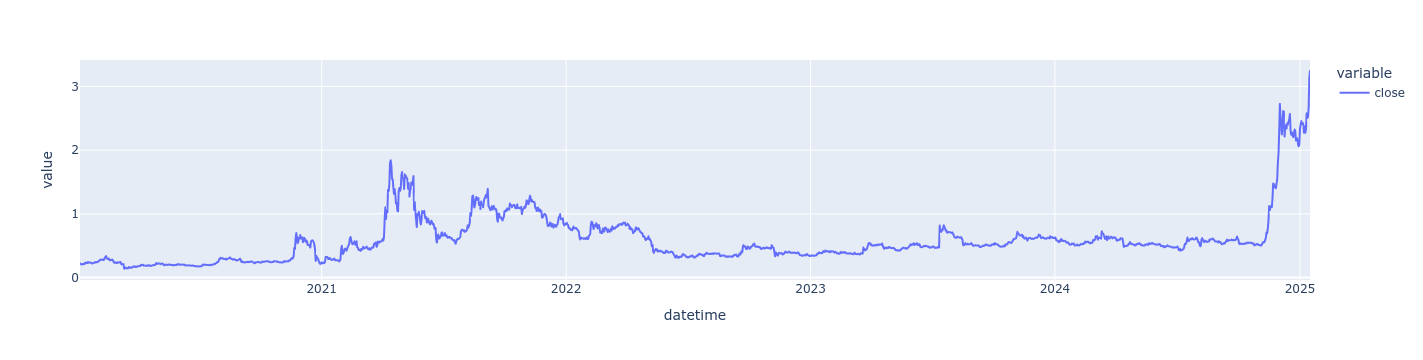

In [131]:
df_ohlc_1d.set_index('datetime')['close'].plot(backend='plotly')

In [94]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    perpetual_contracts = conn.execute(
        """
            SELECT er.exchange, er.instrument 
            FROM amberdata.exchange_reference er
            JOIN amberdata.ohlcv_info_futures oif
                ON er.exchange = oif.exchange
                AND er.instrument = oif.instrument
            WHERE er.contract_period = 'perpetual'
                AND oif.trading_end_date > NOW() - INTERVAL 2 DAY
        """
    ).fetch_df()

display(perpetual_contracts)

,exchange,instrument
0,binance,1000000MOGUSDT
1,binance,1000BONKUSDC
2,binance,1000CATUSDT
3,binance,1000FLOKIUSDT
4,binance,1000SATSUSDT
...,...,...
956,bybit,L3USDT
957,binance,PIXELUSDT
958,bybit,WAVESUSDT
959,bybit,1000XECUSDT


In [75]:
sql("FROM perpetual_contracts where instrument = 'BTCUSDT'")

┌──────────┬────────────┐
│ exchange │ instrument │
│ varchar  │  varchar   │
├──────────┼────────────┤
│ binance  │ BTCUSDT    │
│ bybit    │ BTCUSDT    │
└──────────┴────────────┘

In [129]:
with duckdb.connect(path_data / "crypto_data.db") as conn:
    result = conn.execute('DESCRIBE amberdata.ohlcv_perps_1d').fetchall()

result

[('instrument', 'VARCHAR', 'YES', None, None, None),
 ('open', 'DOUBLE', 'YES', None, None, None),
 ('high', 'DOUBLE', 'YES', None, None, None),
 ('low', 'DOUBLE', 'YES', None, None, None),
 ('close', 'DOUBLE', 'YES', None, None, None),
 ('volume', 'DOUBLE', 'YES', None, None, None),
 ('exchange', 'VARCHAR', 'YES', None, None, None),
 ('datetime', 'TIMESTAMP_NS', 'YES', None, None, None)]

In [ ]:
grouped_contracts = perpetual_contracts.groupby('exchange')

batch_size = 50
for exchange, contracts in grouped_contracts:
    total_instruments = len(contracts)
    for i in range(0, total_instruments, batch_size):
        batch = contracts[i : i + batch_size]
        instruments = batch["instrument"].tolist()

        print(exchange)
        print(instruments)
        print('='*40)